In [17]:
%load_ext autoreload
%autoreload 2

import pyreadstat as prs

raw_df, meta = prs.read_sas7bdat("../nbk/dat/gss7222_r3.sas7bdat")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
import pandas as pd
import numpy as np
import networkx as nx

from adjustText import adjust_text

import sys
sys.path.append('../src')

from transform_df_to_our_standard import transform_dataframe, make_variable_summary, make_vote_supernodes, normalize_columns
from corr_networks import corr_mat_to_partial_corr_mat, cov_mat_to_regularized_partial_corr, generate_random_partial_corr_mat
from triads import count_triads
from belief_changes import make_degree_strength_change_dfs
from make_belief_network import make_conditional_belief_network, convert_graph_to_absolute_value

In [ ]:
df, meta_df = transform_dataframe(raw_df)

In [ ]:
# test normalize columns

normalized_df = normalize_columns(df, meta_df)
for col in df.columns:
    unique_vals = normalized_df[col].unique()
    diff = (np.nanmax(unique_vals) - np.nanmin(unique_vals))
    if (not (diff <= 1)) and (col not in ["YEAR", "BALLOT", "ID"]):
        print(col)
        print(unique_vals)


test_df = pd.DataFrame({
    "A": [1, 2, 3, np.nan],
    "B": [-1, 4, 2, np.nan],
    "D": [2, 3, 3, 5]
})

test_meta_df = pd.DataFrame(columns=["min", "max"])
test_meta_df.loc["A",:] = {"min": 1, "max": 3}
test_meta_df.loc["B",:] = {"min": -1, "max": 4}
test_meta_df.loc["C",:] = {"min": -6, "max": 1}
test_meta_df.loc["D",:] = {"min": 2, "max": 5}

ndf = normalize_columns(test_df, test_meta_df)
ndf
        

,A,B,D
0,0.5,-0.2,0.666667
1,1.0,0.8,1.0
2,1.5,0.4,1.0
3,NaN,NaN,1.666667


In [20]:
vars_to_use = ["YEAR", "PARTYID","POLVIEWS","NATSPAC","NATENVIR","NATHEAL","NATCITY","NATCRIME","NATDRUG","NATEDUC","NATRACE","NATARMS",
"NATAID","NATFARE","NATROAD","NATSOC","NATMASS","NATPARK","NATCHLD","NATSCI","NATENRGY","EQWLTH","SPKATH","COLATH","LIBATH","SPKRAC","COLRAC","LIBRAC","SPKCOM","COLCOM","LIBCOM","SPKMIL","COLMIL","LIBMIL","SPKHOMO",
"COLHOMO","LIBHOMO","SPKMSLM","COLMSLM","LIBMSLM","CAPPUN","GUNLAW","COURTS","GRASS","ATTEND","RELITEN","POSTLIFE","PRAYER","AFFRMACT","WRKWAYUP","HELPFUL",
"FAIR","TRUST","CONFINAN","CONBUS","CONCLERG","CONEDUC","CONFED","CONLABOR","CONPRESS","CONMEDIC","CONTV","CONJUDGE","CONSCI","CONLEGIS","CONARMY","GETAHEAD","FEPOL","ABDEFECT","ABNOMORE","ABHLTH","ABPOOR","ABRAPE","ABSINGLE","ABANY","SEXEDUC","DIVLAW","PREMARSX","TEENSEX","XMARSEX","HOMOSEX","PORNLAW",
"SPANKING","LETDIE1","SUICIDE1","SUICIDE2","POLHITOK","POLABUSE","POLMURDR","POLESCAP","POLATTAK","NEWS","TVHOURS","FECHLD","FEPRESCH","FEFAM","RACDIF1","RACDIF2","RACDIF3",
"RACDIF4","HELPPOOR","MARHOMO", "RACOPEN", "HELPNOT", "HELPBLK","PRESLAST_NONCONFORM", "PRESLAST_DEMREP", "VOTELAST"]

vars_post = ["YEAR","PARTYID","POLVIEWS","NATSPAC","NATENVIR","NATHEAL","NATCITY","NATCRIME","NATDRUG","NATEDUC","NATRACE","NATARMS",
"NATAID","NATFARE","NATROAD","NATSOC","NATMASS","NATPARK","NATCHLD","NATSCI","NATENRGY","EQWLTH","SPKATH","COLATH","LIBATH","SPKRAC","COLRAC","LIBRAC","SPKCOM","COLCOM","LIBCOM","SPKMIL","COLMIL","LIBMIL","SPKHOMO",
"COLHOMO","LIBHOMO","SPKMSLM","COLMSLM","LIBMSLM","CAPPUN","GUNLAW","COURTS","GRASS","ATTEND","RELITEN","POSTLIFE","PRAYER","AFFRMACT","WRKWAYUP","HELPFUL",
"FAIR","TRUST","CONFINAN","CONBUS","CONCLERG","CONEDUC","CONFED","CONLABOR","CONPRESS","CONMEDIC","CONTV","CONJUDGE","CONSCI","CONLEGIS","CONARMY","GETAHEAD","FEPOL","ABDEFECT","ABNOMORE","ABHLTH","ABPOOR","ABRAPE","ABSINGLE","ABANY","SEXEDUC","DIVLAW","PREMARSX","TEENSEX","XMARSEX","HOMOSEX","PORNLAW",
"SPANKING","LETDIE1","SUICIDE1","SUICIDE2","POLHITOK","POLABUSE","POLMURDR","POLESCAP","POLATTAK","NEWS","TVHOURS","FECHLD","FEPRESCH","FEFAM","RACDIF1","RACDIF2","RACDIF3",
"RACDIF4","HELPPOOR","MARHOMO", "RACOPEN", "HELPNOT", "HELPBLK","PRESLAST_NONCONFORM", "PRESLAST_DEMREP", "VOTELAST"]


PRES_variables = [
    'VOTE68', 'VOTE72', 'VOTE76', 'VOTE80', 'VOTE84', 'VOTE88', 'VOTE92', 'VOTE96', 'VOTE00', 'VOTE04', 'VOTE08', 'VOTE12', 'VOTE16', 'VOTE20',
    'VOTE68_ELIGIBLE', 'VOTE72_ELIGIBLE', 'VOTE76_ELIGIBLE', 'VOTE80_ELIGIBLE', 'VOTE84_ELIGIBLE', 'VOTE88_ELIGIBLE', 'VOTE92_ELIGIBLE', 'VOTE96_ELIGIBLE', 'VOTE00_ELIGIBLE', 'VOTE04_ELIGIBLE', 'VOTE08_ELIGIBLE', 'VOTE12_ELIGIBLE', 'VOTE16_ELIGIBLE', 'VOTE20_ELIGIBLE',
    'PRES68_HUMPHREY', 'PRES68_NIXON', 'PRES68_WALLACE', 'PRES68_OTHER', 'PRES68_REFUSED', 'PRES68_NONCONFORM', 'PRES68_DEMREP',
    'PRES72_MCGOVERN', 'PRES72_NIXON', 'PRES72_OTHER', 'PRES72_REFUSED', 'PRES72_WOULDNT_VOTE', 'PRES72_DONT_KNOW', 'PRES72_NONCONFORM', 'PRES72_DEMREP',
    'PRES76_CARTER', 'PRES76_FORD', 'PRES76_OTHER', 'PRES76_REFUSED', 'PRES76_NO_PRES_VOTE', 'PRES76_DONT_KNOW', 'PRES76_NONCONFORM', 'PRES76_DEMREP',
    'PRES80_CARTER', 'PRES80_REAGAN', 'PRES80_ANDERSON', 'PRES80_OTHER', 'PRES80_REFUSED', 'PRES80_DIDNT_VOTE', 'PRES80_DONT_KNOW', 'PRES80_NONCONFORM', 'PRES80_DEMREP',
    'PRES84_MONDALE', 'PRES84_REAGAN', 'PRES84_OTHER', 'PRES84_REFUSED', 'PRES84_NO_PRES_VOTE', 'PRES84_DONT_KNOW', 'PRES84_NONCONFORM', 'PRES84_DEMREP',
    'PRES88_BUSH', 'PRES88_DUKAKIS', 'PRES88_OTHER', 'PRES88_REFUSED', 'PRES88_NO_PRES_VOTE', 'PRES88_DONT_KNOW', 'PRES88_NONCONFORM', 'PRES88_DEMREP',
    'PRES92_CLINTON', 'PRES92_BUSH', 'PRES92_PEROT', 'PRES92_OTHER', 'PRES92_NO_PRES_VOTE', 'PRES92_DONT_KNOW', 'PRES92_NONCONFORM', 'PRES92_DEMREP',
    'PRES96_CLINTON', 'PRES96_DOLE', 'PRES96_PEROT', 'PRES96_OTHER', 'PRES96_DIDNT_VOTE', 'PRES96_DONT_KNOW', 'PRES96_NONCONFORM', 'PRES96_DEMREP',
    'PRES00_GORE', 'PRES00_BUSH', 'PRES00_NADER', 'PRES00_OTHER', 'PRES00_DIDNT_VOTE', 'PRES00_DONT_KNOW', 'PRES00_NONCONFORM', 'PRES00_DEMREP',
    'PRES04_KERRY', 'PRES04_BUSH', 'PRES04_NADER', 'PRES04_NO_PRES_VOTE', 'PRES04_DONT_KNOW', 'PRES04_NONCONFORM', 'PRES04_DEMREP',
    'PRES08_OBAMA', 'PRES08_MCCAIN', 'PRES08_OTHER', 'PRES08_DIDNT_VOTE', 'PRES08_DONT_KNOW', 'PRES08_NONCONFORM', 'PRES08_DEMREP',
    'PRES12_OBAMA', 'PRES12_ROMNEY', 'PRES12_OTHER', 'PRES12_DIDNT_VOTE', 'PRES12_DONT_KNOW', 'PRES12_NONCONFORM', 'PRES12_DEMREP',
    'PRES16_CLINTON', 'PRES16_TRUMP', 'PRES16_OTHER', 'PRES16_DIDNT_VOTE', 'PRES16_DONT_KNOW', 'PRES16_NONCONFORM', 'PRES16_DEMREP',
    'PRES20_BIDEN', 'PRES20_TRUMP', 'PRES20_OTHER', 'PRES20_DIDNT_VOTE', 'PRES20_DONT_KNOW', 'PRES20_NONCONFORM', 'PRES20_DEMREP',
    'IF68WHO_HUMPHREY', 'IF68WHO_NIXON', 'IF68WHO_WALLACE', 'IF68WHO_OTHER', 'IF68WHO_WLDNT_VT_RELIG', 'IF68WHO_DONT_KNOW',
    'IF72WHO_MCGOVERN', 'IF72WHO_NIXON', 'IF72WHO_OTHER', 'IF72WHO_REFUSED', 'IF72WHO_WOULDNT_VOTE', 'IF72WHO_WLDNT_VT_RELIG', 'IF72WHO_DONT_KNOW',
    'IF76WHO_CARTER', 'IF76WHO_FORD', 'IF76WHO_OTHER', 'IF76WHO_REFUSED', 'IF76WHO_WOULDNT_VOTE', 'IF76WHO_DONT_KNOW',
    'IF80WHO_CARTER', 'IF80WHO_REAGAN', 'IF80WHO_ANDERSON', 'IF80WHO_OTHER', 'IF80WHO_WOULDNT_VOTE', 'IF80WHO_REFUSED', 'IF80WHO_DONT_KNOW',
    'IF84WHO_MONDALE', 'IF84WHO_REAGAN', 'IF84WHO_OTHER', 'IF84WHO_WOULDNT_VOTE', 'IF84WHO_DONT_KNOW',
    'IF88WHO_DUKAKIS', 'IF88WHO_BUSH', 'IF88WHO_OTHER', 'IF88WHO_DONT_KNOW',
    'IF92WHO_CLINTON', 'IF92WHO_BUSH', 'IF92WHO_PEROT', 'IF92WHO_OTHER', 'IF92WHO_DONT_KNOW',
    'IF96WHO_CLINTON', 'IF96WHO_DOLE', 'IF96WHO_PEROT', 'IF96WHO_OTHER', 'IF96WHO_DONT_KNOW',
    'IF00WHO_GORE', 'IF00WHO_BUSH', 'IF00WHO_NADER', 'IF00WHO_OTHER', 'IF00WHO_DONT_KNOW',
    'IF04WHO_KERRY', 'IF04WHO_BUSH', 'IF04WHO_NADER', 'IF04WHO_DONT_KNOW',
    'IF08WHO_OBAMA', 'IF08WHO_MCCAIN', 'IF08WHO_OTHER', 'IF08WHO_DONT_KNOW',
    'IF12WHO_OBAMA', 'IF12WHO_ROMNEY', 'IF12WHO_OTHER', 'IF12WHO_DONT_KNOW',
    'IF16WHO_CLINTON', 'IF16WHO_TRUMP', 'IF16WHO_OTHER', 'IF16WHO_CANT_REMEMBER', 'IF16WHO_DONT_KNOW',
    'IF20WHO_BIDEN', 'IF20WHO_TRUMP', 'IF20WHO_OTHER', 'IF20WHO_CANT_REMEMBER', 'IF20WHO_DONT_KNOW'
]


# BROKEN_VARS = ["RELIG",'RACOPEN', 'HELPNOT', 'HELPBLK']
# Ommited from this list: "YEAR", "BALLOT", and "LETDIE1" (this one sucks!)


In [ ]:
# null model stuff

basic_info_df = pd.read_csv("out/1972_to_2018_basic_info.csv")

null_df = {}
basic_info_df["avg_degree_null"] = np.nan
basic_info_df["avg_strength_null"] = np.nan
basic_info_df["max_degree_null"] = np.nan
basic_info_df["max_strength_null"] = np.nan

for i, row in basic_info_df.iterrows():
    num_nodes = int(row["Number of Nodes"])

    if num_nodes in null_df:
        row["null_edges"] = num_nodes
    else:
        avg_degree_sample = []
        avg_strength_sample = []
        max_degree_sample = []
        max_strength_sample = []

        total_strength_sample = []
        for j in range(20):
            corr_mat = generate_random_partial_corr_mat(num_nodes, alpha=0.2)
            
            corr_mat = corr_mat - np.identity(num_nodes)
            degrees = (corr_mat != 0).sum(axis=1)
            strengths = np.abs(corr_mat).sum(axis=1)

            mean_degree = degrees.sum() / num_nodes
            max_degree = np.max(degrees)

            mean_strength = strengths.sum() / num_nodes
            max_strength = np.max(strengths)

            avg_degree_sample.append(mean_degree)
            avg_strength_sample.append(mean_strength)
            max_degree_sample.append(max_degree)
            max_strength_sample.append(max_strength)
        

        row["avg_degree_null"] = sum(avg_degree_sample) / len(avg_degree_sample)
        row["max_degree_null"] = sum(max_degree_sample) / len(max_degree_sample)
        row["avg_strength_null"] = sum(avg_strength_sample) / len(avg_strength_sample)
        row["max_strength_null"] = sum(max_strength_sample) / len(max_strength_sample)

        basic_info_df.loc[i,:] = row

basic_info_df
basic_info_df.to_csv("out/1972_to_2018_basic_info_null_model.csv")

In [ ]:
# makes dataframes for use in making the heatmap and the scatterplot
strength_df, degree_df, change_df = make_degree_strength_change_dfs(df, meta_df, vars_to_use, every_x_years=8, normalize_changes=True)

1.8701485897235979
29.0


C:\Users\vicvi\AppData\Local\Temp\ipykernel_20056\3545756368.py:34: RuntimeWarning: invalid value encountered in divide
  means = value_sum / value_count


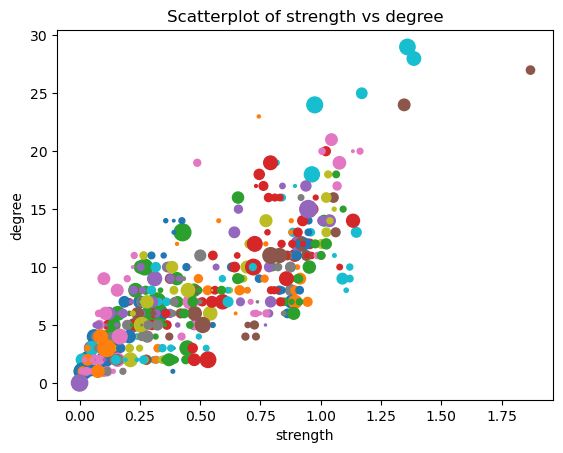

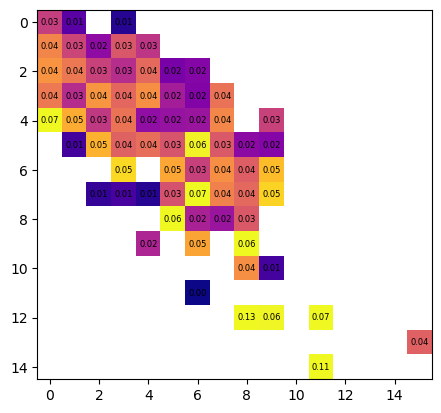

In [ ]:
# this cell plots the scatterplot where the size of the dot is the magnitude of the change
# it also plots the heatmap where the color of the cell is the average change in that particular region

# can change the degree bin and strength bin size here
degree_bin_size = 2
strength_bin_size = 0.12

scatter_fig, scatter_ax = plt.subplots()  # Create a new figure for each column pair
scatter_ax.set_title(f"Scatterplot of strength vs degree")
scatter_ax.set_xlabel(f"strength")
scatter_ax.set_ylabel(f"degree")

strength_ax = strength_df.max().max()
degree_ax = degree_df.max().max()
print(strength_ax)
print(degree_ax)

value_count = np.zeros((np.floor(degree_ax / degree_bin_size).astype(int) + 1, np.floor(strength_ax / strength_bin_size).astype(int) + 1))
value_sum = np.zeros((np.floor(degree_ax / degree_bin_size).astype(int) + 1, np.floor(strength_ax / strength_bin_size).astype(int) + 1))

for col in strength_df.columns:
    diffs = np.abs(np.array(change_df[col]))
    incs = np.where(~np.isnan(diffs), 1, 0)
    vals = np.where(~np.isnan(diffs), diffs, 0)

    np.add.at(value_count, (np.floor(np.array(degree_df[col] / degree_bin_size)).astype(int), np.floor(np.array(strength_df[col]) / strength_bin_size).astype(int)), incs)
    
    np.add.at(value_sum, (np.floor(np.array(degree_df[col] / degree_bin_size)).astype(int), np.floor(np.array(strength_df[col]) / strength_bin_size).astype(int)), 
                            vals)
    
    scatter_ax.scatter(strength_df[col], degree_df[col], s=change_df[col].abs() * 1000)
    # plt.scatter(trimmed_degree_df[col], change_df[col].abs(), s=trimmed_strength_df[col] * 100)

means = value_sum / value_count

cutoff = np.percentile(means[~np.isnan(means)], 90)

chopped_means = np.where(means > cutoff, cutoff, means)

heatmap_fig, heatmap_ax = plt.subplots()
heatmap_ax.imshow(chopped_means, cmap="plasma")

# Add annotations (numeric values) on top of each heatmap cell
for i in range(chopped_means.shape[0]):
    for j in range(chopped_means.shape[1]):

        if ~np.isnan(chopped_means[i, j]):
            plt.text(j, i, f'{means[i, j]:.2f}', ha='center', va='center', color='black', fontsize=6)

In [21]:
outputs_80s = make_conditional_belief_network("POLVIEWS", df, condition_method="negpos", 
                                    variables_of_interest=vars_to_use, years_of_interest=[1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987], 
                                    method="spearman", is_partial=True, regularisation=0.2)

[1. 0.]
[1. 2. 3.]
[-2. -1. -3.]


In [22]:
outputs_10s = make_conditional_belief_network("POLVIEWS", df, condition_method="negpos", 
                                    variables_of_interest=vars_to_use, years_of_interest=[2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015], 
                                    method="spearman", is_partial=True, regularisation=0.2)

[1. 0.]
[1. 2. 3.]
[-2. -1. -3.]


In [24]:
import networkx as nx

lib_78_graph = convert_graph_to_absolute_value(outputs_80s[0]["graph"])
con_78_graph = convert_graph_to_absolute_value(outputs_80s[1]["graph"])

lib_06_graph = convert_graph_to_absolute_value(outputs_10s[0]["graph"])
con_06_graph = convert_graph_to_absolute_value(outputs_10s[1]["graph"])

nx.write_graphml(con_78_graph, f"out/conditioning/78_con.graphml")
nx.write_graphml(lib_78_graph, f"out/conditioning/78_lib.graphml")
# nx.write_graphml(con_12_graph, f"out/conditioning/06_con.graphml")
# nx.write_graphml(lib_12_graph, f"out/conditioning/06_lib.graphml")

In [25]:
print(con_78_graph.number_of_edges())
print(lib_78_graph.number_of_edges())

# print(con_12_graph.number_of_edges())
# print(lib_12_graph.number_of_edges())

288
378


In [26]:
lib_80_corr_mat = outputs_80s[0]["corr_mat"] - np.identity(outputs_80s[0]["corr_mat"].shape[0])
con_80_corr_mat = outputs_80s[1]["corr_mat"] - np.identity(outputs_80s[1]["corr_mat"].shape[0])

lib_10_corr_mat = outputs_10s[0]["corr_mat"] - np.identity(outputs_10s[0]["corr_mat"].shape[0])
con_10_corr_mat = outputs_10s[1]["corr_mat"] - np.identity(outputs_10s[1]["corr_mat"].shape[0])

print("con 80 node count", con_80_corr_mat.shape)
print("lib 80 nodes", lib_80_corr_mat.shape)

print("con 10 nodes", con_10_corr_mat.shape)
print("lib 10 nodes", lib_10_corr_mat.shape)

print("con 80 degree", (con_80_corr_mat != 0).sum() / 2)
print("lib 80 degree", (lib_80_corr_mat != 0).sum() / 2)

print("con 10 degree", (con_10_corr_mat != 0).sum() / 2)
print("lib 10 degree", (lib_10_corr_mat != 0).sum() / 2)

print("con 80 strength", np.abs(con_80_corr_mat).sum() / 2)
print("lib 80 strength", np.abs(lib_80_corr_mat).sum() / 2)

print("con 10 strength", np.abs(con_10_corr_mat).sum() / 2)
print("lib 10 strength", np.abs(lib_10_corr_mat).sum() / 2)

con 80 node count (97, 97)
lib 80 nodes (97, 97)
con 10 nodes (107, 107)
lib 10 nodes (107, 107)
con 80 degree 288.0
lib 80 degree 378.0
con 10 degree 348.0
lib 10 degree 422.0
con 80 strength 20.387563964280464
lib 80 strength 21.747278691618405
con 10 strength 23.93612827322948
lib 10 strength 23.15897486008376


In [27]:
def elongate(variables_of_interest, variables_used, arr):
    dim = len(arr.shape)
    size = len(variables_of_interest)
    elongated_arr = np.zeros((size,) * dim)

    ind_array = [variables_of_interest.index(var) for var in variables_used]

    if dim == 2:
        elongated_arr[ind_array, :][:, ind_array] = arr
    else:
        elongated_arr[ind_array] = arr
    
    return elongated_arr

array([[1.        , 0.91919718],
       [0.91919718, 1.        ]])

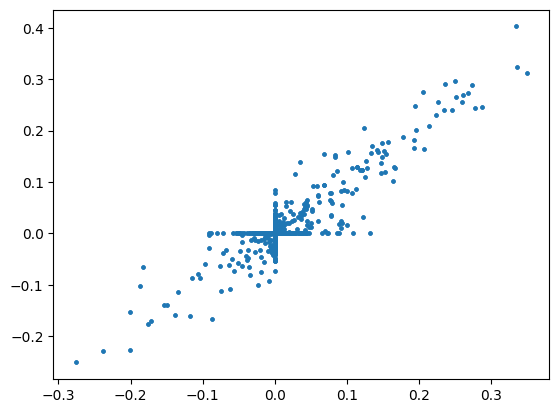

In [28]:
plt.scatter(lib_80_corr_mat, con_80_corr_mat, s=5)
lib_con_80_corr = np.corrcoef(lib_80_corr_mat.flatten(), con_80_corr_mat.flatten())
lib_con_80_corr

array([[1.        , 0.88761554],
       [0.88761554, 1.        ]])

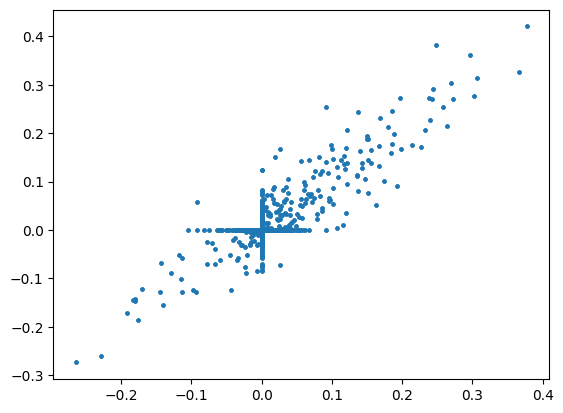

In [29]:
plt.scatter(lib_10_corr_mat, con_10_corr_mat, s=5)
lib_con_10_corr = np.corrcoef(lib_10_corr_mat.flatten(), con_10_corr_mat.flatten())
lib_con_10_corr

In [30]:
print("lib 80s", [outputs_80s[0]["vars"][i] for i in np.argsort(-np.abs(lib_80_corr_mat).sum(axis=0)).astype(int)])
print("con 80s", [outputs_80s[1]["vars"][i] for i in np.argsort(-np.abs(con_80_corr_mat).sum(axis=0)).astype(int)])

lib 80s ['HOMOSEX', 'LIBHOMO', 'COLATH', 'LIBCOM', 'ABNOMORE', 'SPKHOMO', 'ABSINGLE', 'NATRACE', 'SPKATH', 'COLHOMO', 'FEFAM', 'LIBATH', 'LIBMIL', 'SPKCOM', 'SUICIDE1', 'SPKMIL', 'ABANY', 'COLMIL', 'ABPOOR', 'COLCOM', 'ATTEND', 'LIBRAC', 'PREMARSX', 'RACDIF4', 'SPKRAC', 'ABRAPE', 'HELPBLK', 'ABDEFECT', 'COLRAC', 'CONARMY', 'CONLEGIS', 'ABHLTH', 'HELPPOOR', 'FEPRESCH', 'RACDIF1', 'PRESLAST_DEMREP', 'CONFED', 'RELITEN', 'CONJUDGE', 'RACDIF3', 'CONFINAN', 'GRASS', 'FECHLD', 'TRUST', 'LETDIE1', 'RACDIF2', 'CONBUS', 'FAIR', 'XMARSEX', 'PRAYER', 'PORNLAW', 'PARTYID', 'CONCLERG', 'HELPNOT', 'SEXEDUC', 'HELPFUL', 'NATFARE', 'CONSCI', 'CONMEDIC', 'POLESCAP', 'NATARMS', 'CONEDUC', 'POLHITOK', 'POLATTAK', 'EQWLTH', 'CONTV', 'FEPOL', 'YEAR', 'SUICIDE2', 'NATCITY', 'NATSPAC', 'CONPRESS', 'NATDRUG', 'RACOPEN', 'CAPPUN', 'NATCRIME', 'POLABUSE', 'NATHEAL', 'POSTLIFE', 'NATEDUC', 'POLMURDR', 'TVHOURS', 'CONLABOR', 'NATMASS', 'NATENVIR', 'NATSOC', 'VOTELAST', 'NEWS', 'NATPARK', 'NATROAD', 'GETAHEAD', 'G

97
(97,)


NameError: name 'diff_cutoff' is not defined

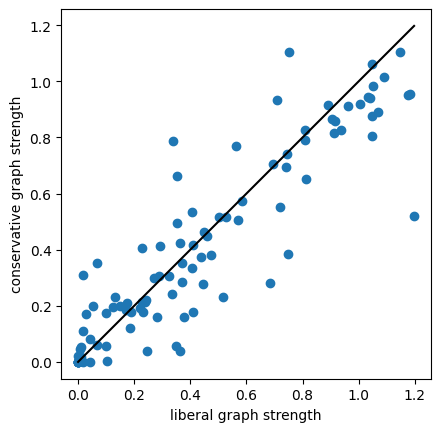

In [33]:
x = np.abs(lib_80_corr_mat).sum(axis=0)
y = np.abs(con_80_corr_mat).sum(axis=0)
labels = outputs_80s[0]["vars"]

print(len(labels))
print(x.shape)




fig, ax = plt.subplots()
ax.set_aspect("equal")

ax.plot([0, max(np.append(x, y))], [0, max(np.append(x, y))], color='black')
ax.scatter(x, y)

ax.set_xlabel("liberal graph strength")
ax.set_ylabel("conservative graph strength")

texts = []
for i, label in enumerate(labels):
    if np.abs(x[i] - y[i]) > diff_cutoff or x[i] > abs_cutoff or y[i] > abs_cutoff:
        texts.append(ax.text(x[i], y[i], label, ha='center', va='bottom', fontsize=8))

# Adjust text to avoid overlap
adjust_text(texts, arrowprops=dict(arrowstyle='-', color='yellow'))

line1 = 0.5 * np.ones_like(x)
line2 = -0.5 * np.ones_like(x)
# Shade the region between lines
# plt.fill_between(max(x), line1, line2, color='gray', alpha=0.3, label='Shaded Region')


In [101]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors

def labeled_scatter_hist(var_names, x, y, xlabel="", ylabel="", color_scheme='viridis'):

    # Start with a square Figure.
    
    cm = 1/2.54  # centimeters in inches
    
    fig = plt.figure(figsize=(1*15*cm, 1*15*cm), dpi=300)
    # Add a gridspec with two rows and two columns and a ratio of 1 to 4 between
    # the size of the marginal axes and the main axes in both directions.
    # Also adjust the subplot parameters for a square plot.
    gs = fig.add_gridspec(2, 2,  width_ratios=(4, 1), height_ratios=(1, 4),
                        left=0.1, right=0.9, bottom=0.1, top=0.9,
                        wspace=0.05, hspace=0.05)
    # Create the Axes.
    ax = fig.add_subplot(gs[1, 0])
    ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
    ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)

    # no labels
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)

    x_max = np.max(x)
    y_max = np.max(y)

    val_max = max(x_max, y_max)
    padding = val_max / 100

    ax.set_xlim(-padding, val_max + padding)  # Set x-axis limit from 0 to 1
    ax.set_ylim(-padding, val_max + padding)  # Set y-axis limit from 0 to 1

    # the scatter plot:
    x_axis = np.linspace(-padding, val_max + padding, 10)
    diffs = np.abs(x - y)
    median_diff = np.median(diffs[diffs != 0])
    below_line = x_axis - median_diff
    above_line = x_axis + median_diff
    ax.fill_between(x_axis, below_line, above_line, alpha=0.2)

    ax.plot([-padding, val_max + padding], [-padding, val_max + padding], color='black')

    cmap = plt.get_cmap(color_scheme)
    colors = cmap(np.linspace(0, 1, len(x)))  # Generate colors from the colormap
    dotcolor = colors[25]
    ax.scatter(x, y, c=dotcolor)  # Use generated colors here

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    diff_cutoff = np.percentile(np.abs(x - y), 88)
    x_cutoff = np.percentile(x, 95)
    y_cutoff = np.percentile(y, 95)

    texts = []
    for i, label in enumerate(var_names):
        if np.abs(x[i] - y[i]) > diff_cutoff or x[i] > x_cutoff or y[i] > y_cutoff:
            texts.append(ax.text(x[i], y[i], label, ha='center', va='bottom', fontsize=8))

    # Adjust text to avoid overlap
    adjust_text(texts, ax=ax)

    # now determine nice limits by hand:
    binwidth = (val_max + 2 * padding) / 6
    xymax = max(np.max(np.abs(x)), np.max(np.abs(y)))
    lim = (int(xymax/binwidth) + 1) * binwidth

    bin_color = colors[50]

    bins = np.arange(-lim, lim + binwidth, binwidth)
    ax_histx.hist(x, bins=bins, color=bin_color)
    ax_histx.axvline(x.mean(), color='k', linestyle='dashed', linewidth=1)
    ax_histy.hist(y, bins=bins, orientation='horizontal', color=bin_color)
    ax_histy.axhline(y.mean(), color='k', linestyle='dashed', linewidth=1)

    plt.show()  # Show the plot
    # Save the plot as an svg
    # fig.savefig("out/fig3_scatter_hist_degree_libcon_10s.svg", format="svg")



C:\Users\timbo\AppData\Local\Temp\ipykernel_17436\3473660622.py:49: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(x, y, c=dotcolor)  # Use generated colors here


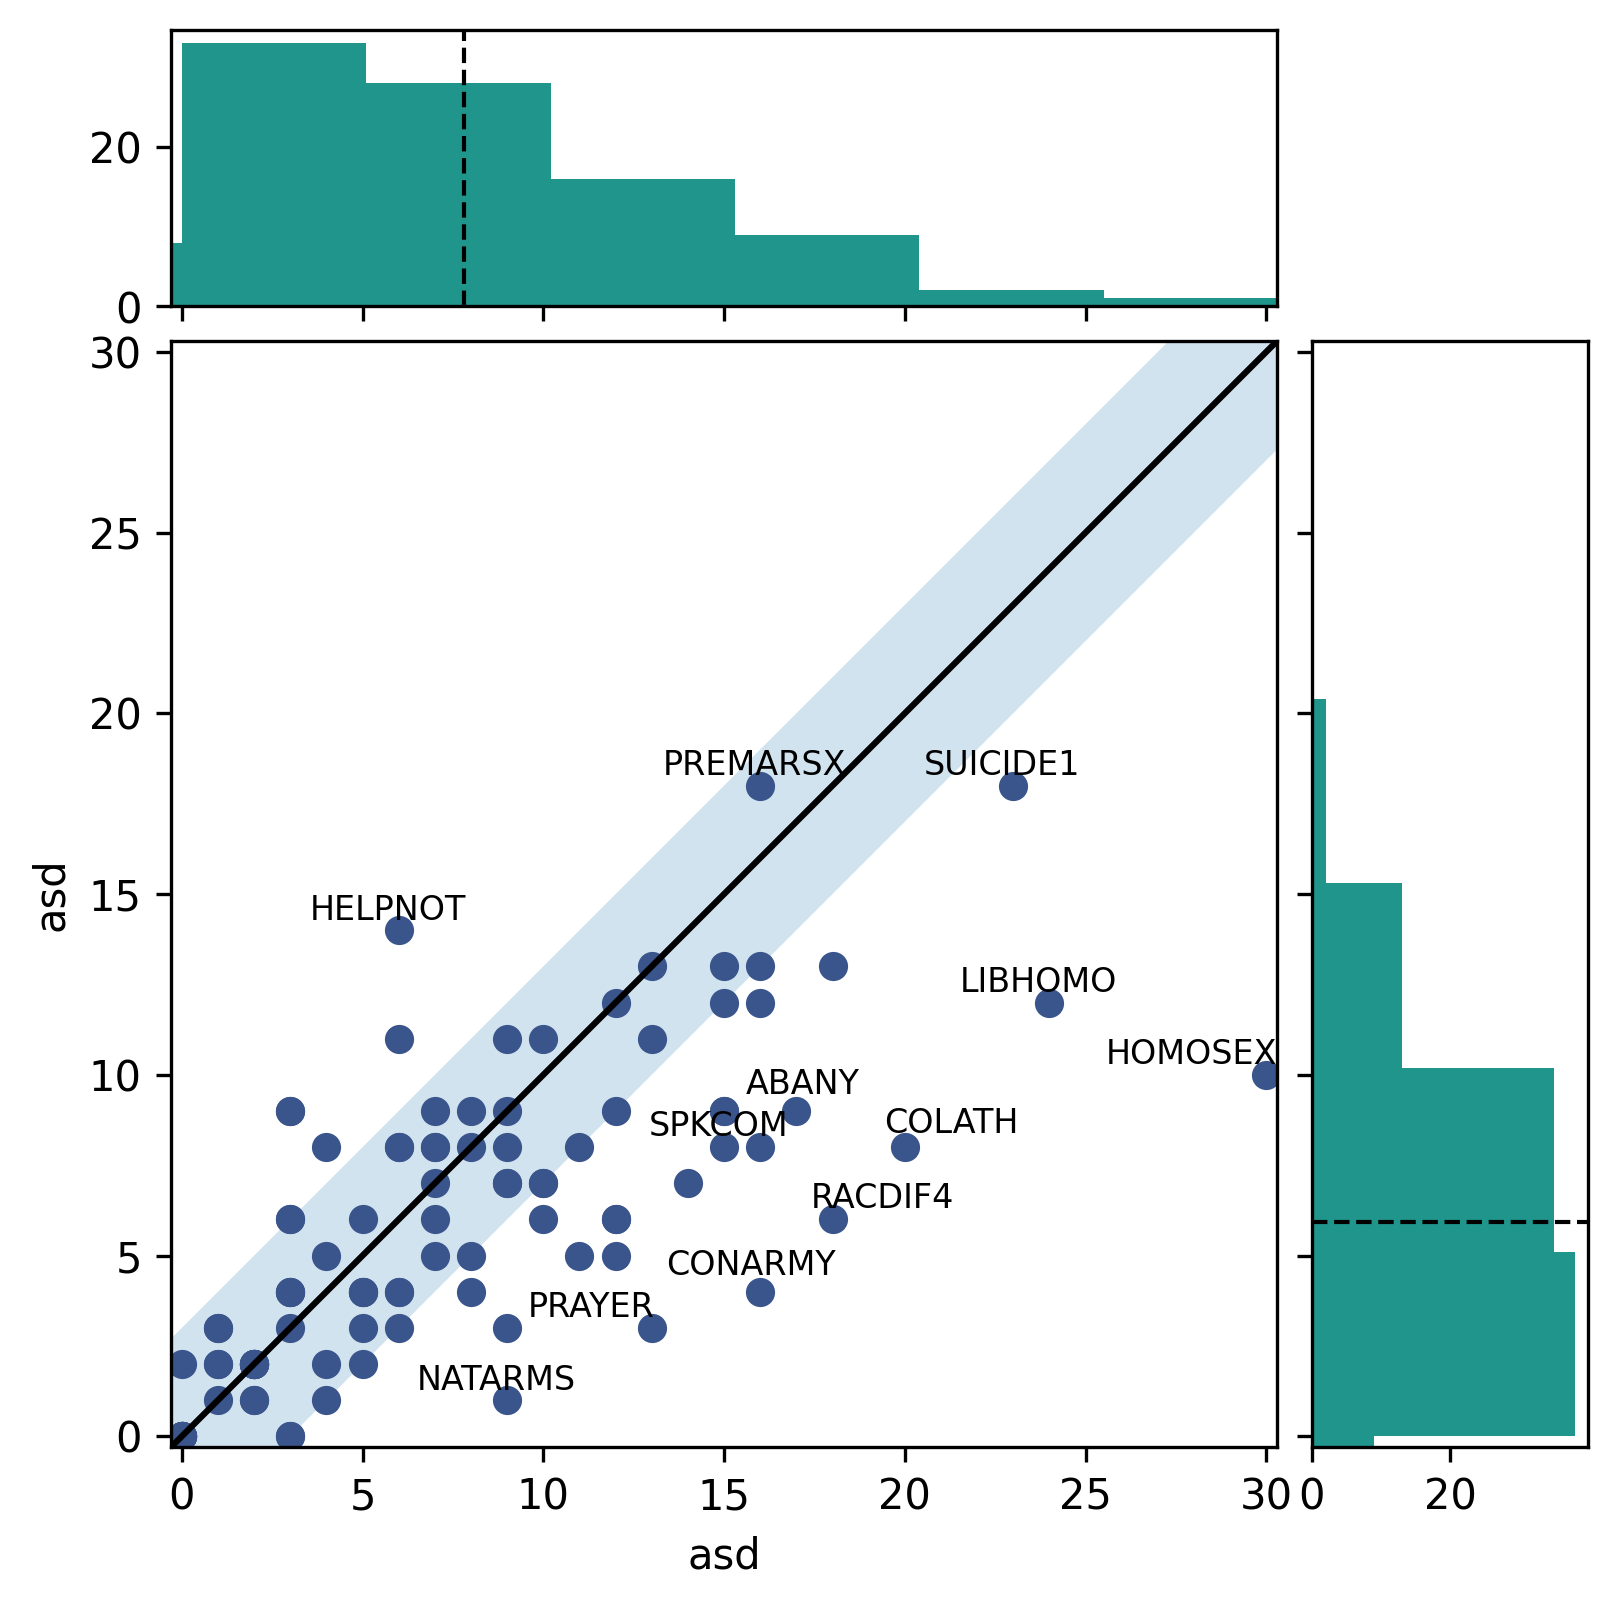

In [102]:
x = (lib_80_corr_mat != 0).sum(axis=0)
y =(con_80_corr_mat != 0).sum(axis=0)
var_names = outputs_80s[0]["vars"]

labeled_scatter_hist(var_names, x, y, xlabel="asd", ylabel="asd")

In [ ]:
print(x)

[ 2  3  0 10  3  4  4  1  3  3 13  9  0  6  0  3  3  1  6 15 20 16  5  5
 10 16 14 13 12 10 12 15 12 24  2  0  0 12 15  9  2 13  2  2  5  9  8  9
  7  7  3  6  8  6  8  7  9 16  0  6  9 16  3 10  7 15 17  9  0 16  7 30
 15  8 23  5  5  4  1  2  2  1  3  4  2 18  5 12 11 18  6  3  6 11  0  7
  1]


C:\Users\timbo\AppData\Local\Temp\ipykernel_17436\2171911453.py:49: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(x, y, c=dotcolor)  # Use generated colors here


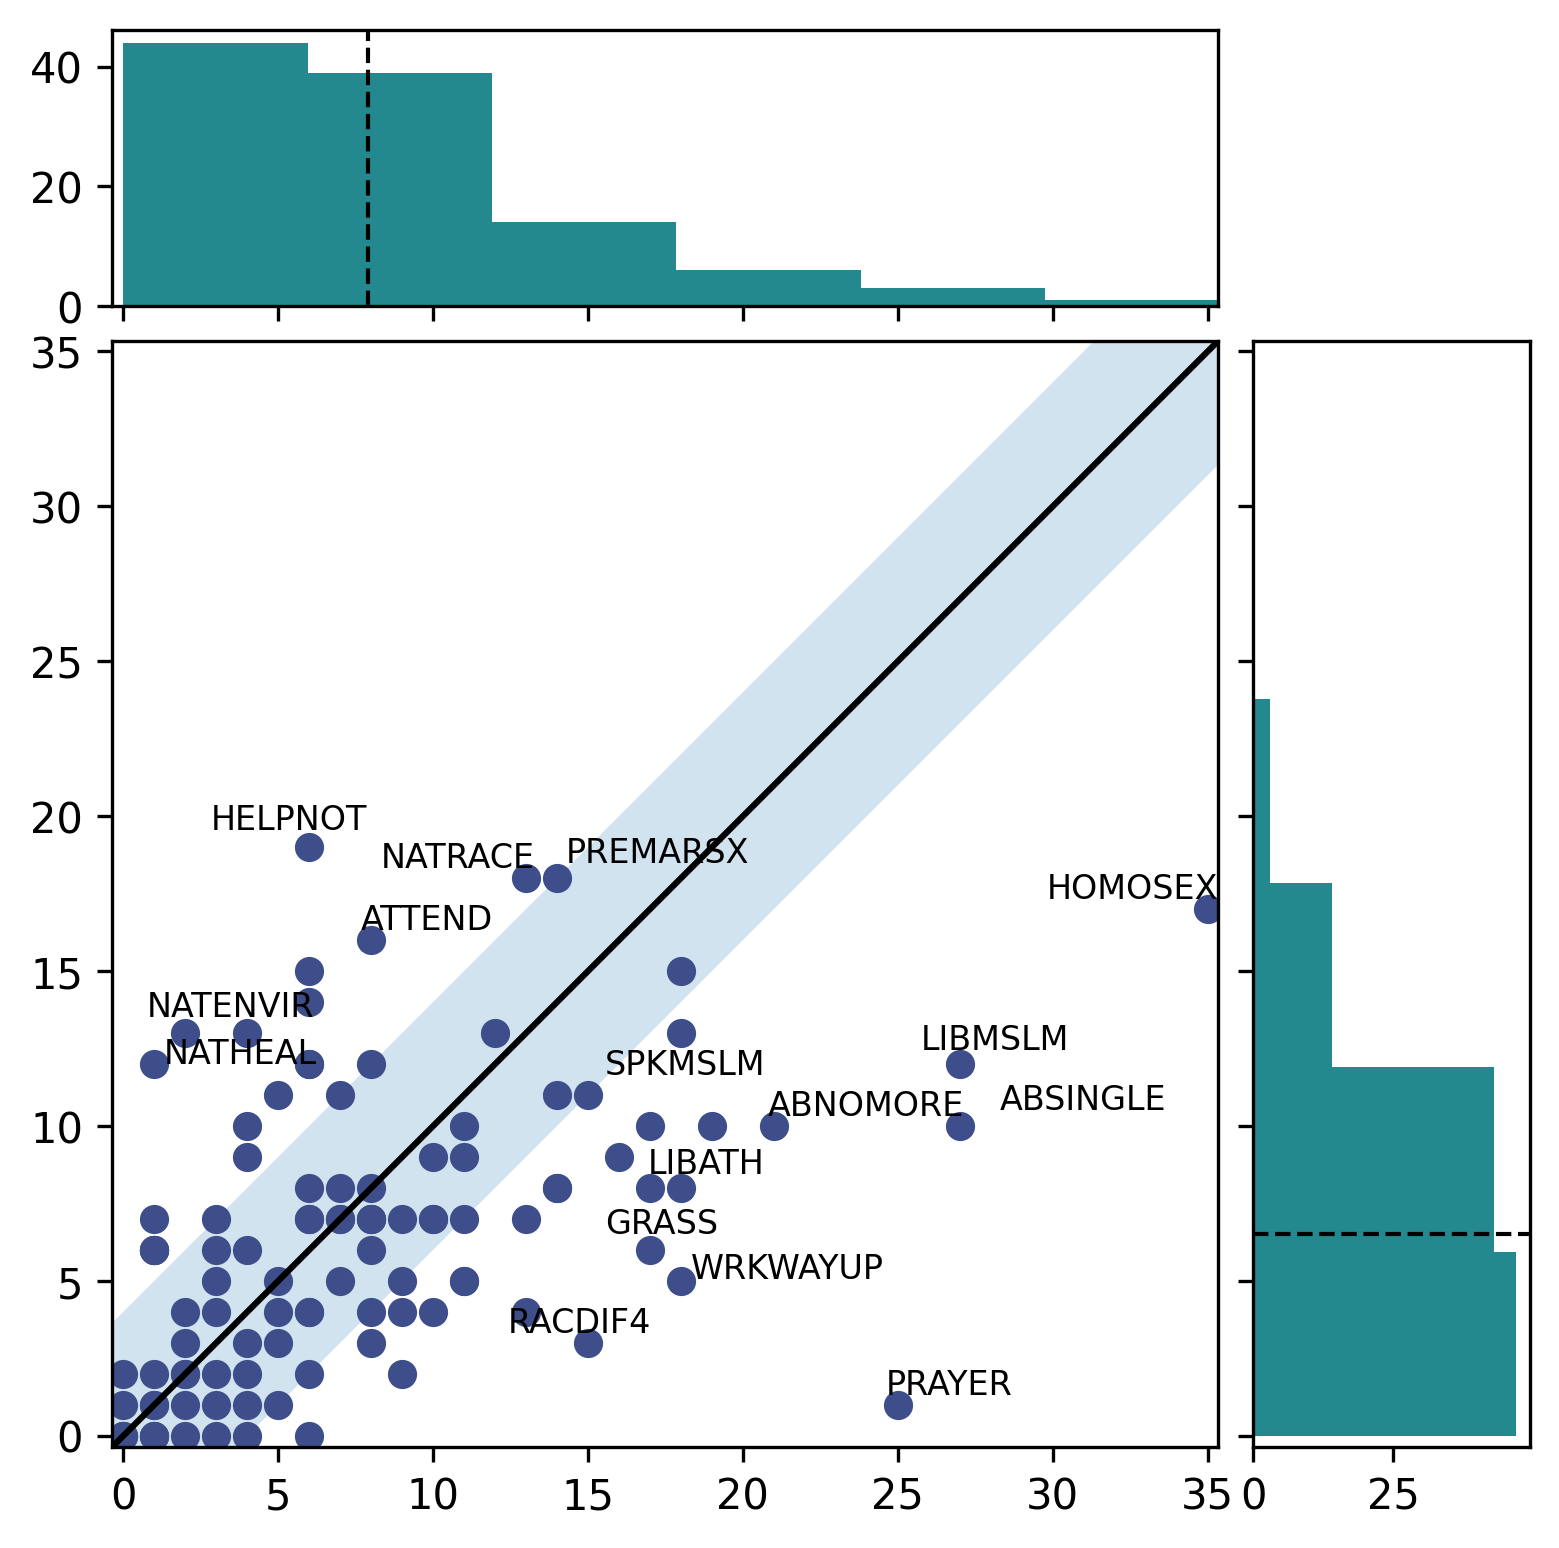

In [100]:
x = (lib_10_corr_mat != 0).sum(axis=0)
y =(con_10_corr_mat != 0).sum(axis=0)
var_names = outputs_10s[0]["vars"]

labeled_scatter_hist(var_names, x, y, xlabel="asd", ylabel="asd")

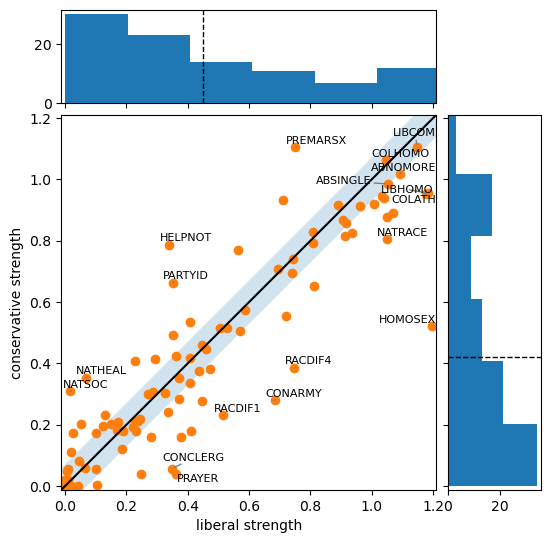

In [ ]:
x = np.abs(lib_80_corr_mat).sum(axis=0)
y = np.abs(con_80_corr_mat).sum(axis=0)
var_names = outputs_80s[0]["vars"]

labeled_scatter_hist(var_names, x, y, xlabel="liberal strength", ylabel="conservative strength")

In [ ]:
x = np.abs(lib_10_corr_mat).sum(axis=0)
y = np.abs(con_10_corr_mat).sum(axis=0)
var_names = outputs_10s[0]["vars"]

labeled_scatter_hist(var_names, x, y, xlabel="liberal strength", ylabel="conservative strength")

NameError: name 'np' is not defined

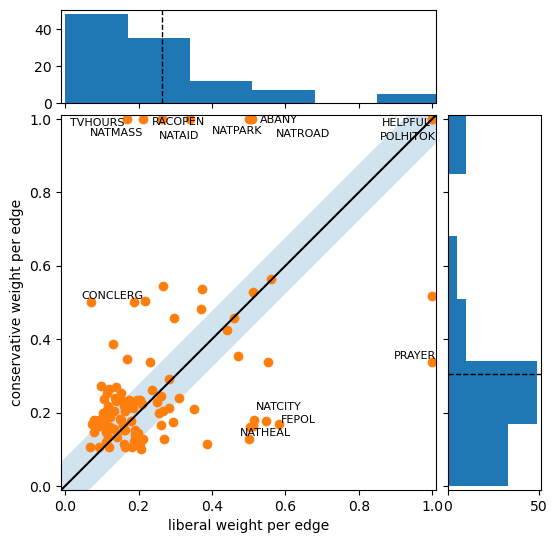

In [ ]:
x = (np.abs(lib_10_corr_mat).sum(axis=0) + 1) / ((lib_10_corr_mat != 0).sum(axis=0) + 1)
y = (np.abs(con_10_corr_mat).sum(axis=0) + 1) / ((con_10_corr_mat != 0).sum(axis=0) + 1)

var_names = outputs_10s[0]["vars"]

labeled_scatter_hist(var_names, x, y, xlabel="liberal weight per edge", ylabel="conservative weight per edge")

In [ ]:
x = np.linspace(0, 10, 11)
x

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.])

0.1593752851250979


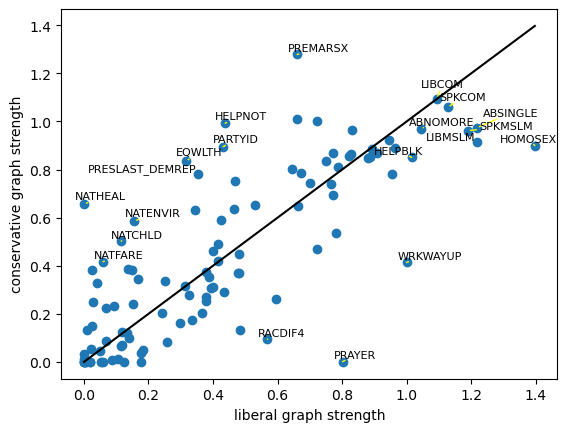

In [ ]:
x = np.abs(lib_10_corr_mat).sum(axis=0)
y = np.abs(con_10_corr_mat).sum(axis=0)

print(np.abs(x - y).mean())
diff_cutoff = np.percentile(np.abs(x - y), 88)
abs_cutoff = np.percentile(np.append(x, y), 95)

labels = outputs_10s[0]["vars"]
plt.plot([0, max(np.append(x, y))], [0, max(np.append(x, y))], color='black')
plt.scatter(x, y)

plt.xlabel("liberal graph strength")
plt.ylabel("conservative graph strength")

texts = []
for i, label in enumerate(labels):
    if np.abs(x[i] - y[i]) > diff_cutoff or x[i] > abs_cutoff or y[i] > abs_cutoff:
        texts.append(plt.text(x[i], y[i], label, ha='center', va='bottom', fontsize=8))

# Adjust text to avoid overlap
adjust_text(texts, arrowprops=dict(arrowstyle='-', color='yellow'))

In [ ]:
print("lib 10s", [outputs_10s[0]["vars"][i] for i in np.argsort(-np.abs(lib_10_corr_mat).sum(axis=0)).astype(int)])
print("con 10s", [outputs_10s[1]["vars"][i] for i in np.argsort(-np.abs(con_10_corr_mat).sum(axis=0)).astype(int)])

lib 10s ['HOMOSEX', 'LIBMSLM', 'ABSINGLE', 'SPKMSLM', 'SPKCOM', 'LIBCOM', 'ABNOMORE', 'HELPBLK', 'WRKWAYUP', 'ABPOOR', 'LIBATH', 'ABANY', 'LIBMIL', 'LIBHOMO', 'COLATH', 'SPKMIL', 'COLMIL', 'COLMSLM', 'ABRAPE', 'PRAYER', 'SPKATH', 'RELITEN', 'SUICIDE1', 'SPKHOMO', 'COLHOMO', 'SPKRAC', 'ABDEFECT', 'FEFAM', 'COLRAC', 'LIBRAC', 'COLCOM', 'PREMARSX', 'NATRACE', 'ATTEND', 'TRUST', 'RACDIF4', 'LETDIE1', 'CONCLERG', 'FAIR', 'FEPRESCH', 'CONFINAN', 'HELPPOOR', 'CONLEGIS', 'HELPNOT', 'RACDIF1', 'PARTYID', 'CONJUDGE', 'ABHLTH', 'POLESCAP', 'POLHITOK', 'TEENSEX', 'AFFRMACT', 'POLATTAK', 'CONBUS', 'NATENRGY', 'FECHLD', 'RACDIF3', 'PRESLAST_DEMREP', 'CONFED', 'GRASS', 'HELPFUL', 'EQWLTH', 'CONSCI', 'POLMURDR', 'CONARMY', 'CONMEDIC', 'CONTV', 'NATSCI', 'NATARMS', 'SPANKING', 'CONPRESS', 'NATENVIR', 'XMARSEX', 'CONEDUC', 'VOTELAST', 'PORNLAW', 'SUICIDE2', 'RACDIF2', 'YEAR', 'POLABUSE', 'NATCHLD', 'CAPPUN', 'POSTLIFE', 'NATCITY', 'TVHOURS', 'NATDRUG', 'FEPOL', 'NATMASS', 'NATFARE', 'NATAID', 'NATSPAC',

In [ ]:
print("lib 80s", [outputs_80s[0]["vars"][i] for i in np.argsort(-(lib_80_corr_mat != 0).sum(axis=0)).astype(int)])
print("con 80s", [outputs_80s[1]["vars"][i] for i in np.argsort(-(con_80_corr_mat != 0).sum(axis=0)).astype(int)])

lib 80s ['HOMOSEX', 'LIBHOMO', 'SUICIDE1', 'COLATH', 'RACDIF4', 'FEFAM', 'ABANY', 'SPKCOM', 'CONARMY', 'LIBATH', 'ABNOMORE', 'PREMARSX', 'ATTEND', 'PORNLAW', 'SPKHOMO', 'SPKATH', 'ABSINGLE', 'COLCOM', 'PRAYER', 'LIBCOM', 'NATRACE', 'COLHOMO', 'RACDIF2', 'LIBMIL', 'GRASS', 'SPKMIL', 'RACDIF3', 'HELPBLK', 'COLMIL', 'NATSPAC', 'ABPOOR', 'LIBRAC', 'CONFINAN', 'RELITEN', 'CONLEGIS', 'ABDEFECT', 'NATARMS', 'SEXEDUC', 'CONCLERG', 'CONJUDGE', 'CONMEDIC', 'LETDIE1', 'CONBUS', 'CONSCI', 'ABRAPE', 'XMARSEX', 'CONFED', 'PRESLAST_DEMREP', 'CONEDUC', 'NATFARE', 'CONPRESS', 'EQWLTH', 'CONTV', 'FEPOL', 'HELPNOT', 'HELPPOOR', 'TRUST', 'SPKRAC', 'RACDIF1', 'SUICIDE2', 'POLHITOK', 'COLRAC', 'POLABUSE', 'NATCITY', 'NATHEAL', 'FECHLD', 'PARTYID', 'NATENVIR', 'NATDRUG', 'NATSOC', 'NATEDUC', 'RACOPEN', 'ABHLTH', 'NATMASS', 'TVHOURS', 'CONLABOR', 'FEPRESCH', 'POLATTAK', 'POLESCAP', 'YEAR', 'CAPPUN', 'FAIR', 'HELPFUL', 'POSTLIFE', 'NATCRIME', 'NATPARK', 'POLMURDR', 'VOTELAST', 'NEWS', 'COURTS', 'GETAHEAD', 'NA

In [ ]:
print("lib 10s", [outputs_10s[0]["vars"][i] for i in np.argsort(-(lib_10_corr_mat != 0).sum(axis=0)).astype(int)])
print("con 10s", [outputs_10s[1]["vars"][i] for i in np.argsort(-(con_10_corr_mat != 0).sum(axis=0)).astype(int)])

lib 10s ['HOMOSEX', 'LIBMSLM', 'ABSINGLE', 'PRAYER', 'ABNOMORE', 'SPKMSLM', 'SUICIDE1', 'WRKWAYUP', 'LIBATH', 'SPKCOM', 'FEFAM', 'GRASS', 'LIBHOMO', 'ABPOOR', 'RACDIF4', 'ABANY', 'COLATH', 'LIBCOM', 'PREMARSX', 'HELPBLK', 'NATRACE', 'COLCOM', 'TRUST', 'ABRAPE', 'SPKATH', 'POLHITOK', 'CONCLERG', 'TEENSEX', 'SPKMIL', 'RELITEN', 'CONSCI', 'COLHOMO', 'LIBMIL', 'XMARSEX', 'CONFED', 'POLMURDR', 'RACDIF3', 'CONFINAN', 'ATTEND', 'CONLEGIS', 'CONARMY', 'CONBUS', 'COLMSLM', 'SPKHOMO', 'NATENRGY', 'ABDEFECT', 'LETDIE1', 'CONJUDGE', 'CONMEDIC', 'RACDIF1', 'LIBRAC', 'PORNLAW', 'SPANKING', 'SUICIDE2', 'HELPNOT', 'VOTELAST', 'NATARMS', 'PARTYID', 'NATCHLD', 'EQWLTH', 'AFFRMACT', 'SPKRAC', 'COLMIL', 'CONEDUC', 'POLATTAK', 'CAPPUN', 'COLRAC', 'RACDIF2', 'HELPPOOR', 'ABHLTH', 'FAIR', 'NATFARE', 'NATSCI', 'PRESLAST_DEMREP', 'TVHOURS', 'NATMASS', 'NATEDUC', 'NATAID', 'CONLABOR', 'FEPOL', 'FEPRESCH', 'CONTV', 'NATDRUG', 'FECHLD', 'NATSPAC', 'NATENVIR', 'NEWS', 'POLESCAP', 'YEAR', 'HELPFUL', 'POLABUSE', 'CO

In [ ]:
for u, v, d in lib_78_graph.edges(data=True):
    d['abs_weight'] = abs(d['weight'])

for u, v, d in con_78_graph.edges(data=True):
    d['abs_weight'] = abs(d['weight'])

for u, v, d in lib_06_graph.edges(data=True):
    d['abs_weight'] = abs(d['weight'])

for u, v, d in con_06_graph.edges(data=True):
    d['abs_weight'] = abs(d['weight'])

In [ ]:
lib_78_communities = nx.community.greedy_modularity_communities(lib_78_graph, weight="abs_weight")
nx.community.modularity(lib_78_graph, lib_78_communities)

0.6363584930462022

In [ ]:
con_78_communities = nx.community.greedy_modularity_communities(con_78_graph, weight="abs_weight")
nx.community.modularity(con_78_graph, con_78_communities)

0.7064060461371355

In [ ]:
lib_06_communities = nx.community.greedy_modularity_communities(lib_06_graph, weight="abs_weight")
nx.community.modularity(lib_06_graph, lib_06_communities)

0.6589079756708695

In [ ]:
con_06_communities = nx.community.greedy_modularity_communities(con_06_graph, weight="abs_weight")
nx.community.modularity(con_06_graph, con_06_communities)

0.7208590391162814

In [ ]:
lib_78_communities

[frozenset({'CAPPUN',
            'EQWLTH',
            'HELPBLK',
            'HELPNOT',
            'HELPPOOR',
            'NATARMS',
            'NATCITY',
            'NATENVIR',
            'NATFARE',
            'NATHEAL',
            'NATMASS',
            'NATPARK',
            'NATRACE',
            'NATSOC',
            'PARTYID',
            'PRESLAST_DEMREP',
            'RACDIF1',
            'RACDIF3',
            'RACDIF4',
            'RACOPEN',
            'YEAR'}),
 frozenset({'COLATH',
            'COLCOM',
            'COLHOMO',
            'COLMIL',
            'COLRAC',
            'LIBATH',
            'LIBCOM',
            'LIBHOMO',
            'LIBMIL',
            'LIBRAC',
            'POLABUSE',
            'POLMURDR',
            'RACDIF2',
            'SPKATH',
            'SPKCOM',
            'SPKHOMO',
            'SPKMIL',
            'SPKRAC'}),
 frozenset({'CONARMY',
            'CONBUS',
            'CONCLERG',
            'CONEDUC',
            '

In [ ]:
{k: v for k, v in sorted(closeness_con_80_dict.items(), key=lambda item: -item[1])}

{'NATSPAC': 0.3799126637554585,
 'LIBCOM': 0.3799126637554585,
 'HELPPOOR': 0.36401673640167365,
 'LIBATH': 0.36401673640167365,
 'FEFAM': 0.3466135458167331,
 'SPKATH': 0.34523809523809523,
 'RACDIF2': 0.3438735177865613,
 'EQWLTH': 0.33852140077821014,
 'CONSCI': 0.3372093023255814,
 'PREMARSX': 0.3372093023255814,
 'LIBMIL': 0.3346153846153846,
 'SPKCOM': 0.3283018867924528,
 'SUICIDE1': 0.3258426966292135,
 'LIBHOMO': 0.3246268656716418,
 'SEXEDUC': 0.31985294117647056,
 'PORNLAW': 0.31868131868131866,
 'ABNOMORE': 0.3175182481751825,
 'NATRACE': 0.31521739130434784,
 'RACDIF4': 0.31521739130434784,
 'HELPNOT': 0.3140794223826715,
 'SPKHOMO': 0.3140794223826715,
 'COLCOM': 0.3096085409252669,
 'HELPBLK': 0.30742049469964666,
 'ABANY': 0.30742049469964666,
 'CONFED': 0.30742049469964666,
 'CONLABOR': 0.30633802816901406,
 'ATTEND': 0.3041958041958042,
 'LIBRAC': 0.30313588850174217,
 'CONBUS': 0.30313588850174217,
 'CONEDUC': 0.30103806228373703,
 'CONJUDGE': 0.30103806228373703,
 '

In [ ]:
partial = True
for year in years:
    for threshold in thresholds:
        # for partial in [True, False]:
            correlation_matrix = outputs[year][partial][threshold]["corr_mat"]
            BN = outputs[year][partial][threshold]["network"]
            variables_list = outputs[year][partial][threshold]["variables"]

            print(f"{year}, partial corrs: {partial}, threshold: {threshold}")

            correlation_matrix_unique = correlation_matrix[np.triu_indices(correlation_matrix.shape[0], k=1)]

            # Print the max and min correlation values
            print(f"Max correlation: {np.max(correlation_matrix_unique)}")
            print(f"Min correlation: {np.min(correlation_matrix_unique)}")

            # Print num nodes and edges in graph
            print(f"Number of nodes: {len(BN.nodes)}")
            print(f"Number of edges: {len(BN.edges)}")
        
            """
            # Save the graph as graphml into the folder "outputs"
            # make the name include the years of interest
            years_name = "_".join([str(year) for year in years_of_interest])
            # filename = f"{years_name}.graphml"
            filename = "asdasd.graphml"
            nx.write_graphml(BN, f"out/{filename}")
            """

In [ ]:
pd.set_option('display.max_rows', None)  # Show all rows without truncation

print(df.loc[(df["YEAR"] == 2002) & df["CONEDUC"].isna() & ((df["BALLOT"] == 2.0) | (df["BALLOT"] == 3.0))].notna().any(axis=0))

In [ ]:
filled_vars, percent_filled, partially_complete = make_variable_summary(df)

In [ ]:
filled_vars.shape

(75, 303)

In [ ]:
percent_filled.shape

(75, 303)

In [ ]:
percent_filled.to_csv("variable_completion_votes.csv")

In [ ]:
nonvoting_percent_filled = percent_filled.drop(PRES_variables, axis=1)
nonvoting_percent_filled.to_csv("variable_completion.csv")

In [ ]:
[coord for coord in partially_complete if coord[1] not in PRES_variables]

[((1988.0, 1.0), 'NATENVIR'),
 ((1988.0, 2.0), 'NATENVIR'),
 ((1988.0, 3.0), 'NATENVIR'),
 ((1989.0, 1.0), 'NATENVIR'),
 ((1989.0, 2.0), 'NATENVIR'),
 ((1989.0, 3.0), 'NATENVIR'),
 ((1990.0, 1.0), 'NATENVIR'),
 ((1990.0, 2.0), 'NATENVIR'),
 ((1990.0, 3.0), 'NATENVIR'),
 ((1991.0, 1.0), 'NATENVIR'),
 ((1991.0, 2.0), 'NATENVIR'),
 ((1991.0, 3.0), 'NATENVIR'),
 ((1993.0, 1.0), 'NATENVIR'),
 ((1993.0, 2.0), 'NATENVIR'),
 ((1993.0, 3.0), 'NATENVIR'),
 ((1994.0, 1.0), 'NATENVIR'),
 ((1994.0, 1.0), 'AFFRMACT'),
 ((1994.0, 1.0), 'WRKWAYUP'),
 ((1994.0, 2.0), 'NATENVIR'),
 ((1994.0, 2.0), 'AFFRMACT'),
 ((1994.0, 2.0), 'WRKWAYUP'),
 ((1994.0, 3.0), 'NATENVIR'),
 ((1996.0, 1.0), 'NATENVIR'),
 ((1996.0, 2.0), 'NATENVIR'),
 ((1996.0, 2.0), 'RACOPEN'),
 ((1996.0, 3.0), 'NATENVIR'),
 ((1996.0, 3.0), 'RACOPEN'),
 ((1996.0, 3.0), 'FECHLD'),
 ((1996.0, 3.0), 'FEPRESCH'),
 ((1996.0, 3.0), 'FEFAM'),
 ((1998.0, 1.0), 'NATENVIR'),
 ((1998.0, 1.0), 'TRUST'),
 ((1998.0, 2.0), 'NATENVIR'),
 ((1998.0, 3.0), 'NA

In [ ]:
data = {
    'A': [1.0, np.nan, 3.0, 4.0],
    'B': [5.0, 6.0, np.nan, 8.0],
    'C': [np.nan, 10.0, 11.0, 12.0]
}

df = pd.DataFrame(data)

,A,B,C
0,True,True,False
1,False,True,True
2,True,False,True
3,True,True,True


In [ ]:
import networkx as nx
from itertools import combinations

def find_triads(G, threshhold=0):
    nodes = G.nodes()
    triads = list(combinations(nodes, 3))
    positive_triads = []
    negative_triads = []

    for triad in triads:
        edges = [(triad[0], triad[1]), (triad[1], triad[2]), (triad[0], triad[2])]
        weights = [G[u][v]['weight'] for u, v in edges if G.has_edge(u, v)]

        # Ensure all edges exist, otherwise skip
        if len(weights) == 3:
            if abs(weights[0]) > threshhold and abs(weights[1]) > threshhold and abs(weights[2]) > threshhold:
            
                product = weights[0] * weights[1] * weights[2]
                if product > 0:
                    positive_triads.append(triad)
                elif product < 0:
                    negative_triads.append(triad)

    return positive_triads, negative_triads

# Create graph and find the triads, and print the number of triads
G = BN
positive_triads, negative_triads = find_triads(G, threshhold=0.2)
print(f"Number of balanced triads: {len(positive_triads)}")
print(f"Number of unbalanced triads: {len(negative_triads)}")

# Print the triads
print("Balanced triads:", positive_triads)
print("Unbalanced triads:", negative_triads)

In [ ]:
# Print the histogram of the correlation matrix
import matplotlib.pyplot as plt
plt.hist(correlation_matrix.flatten(), bins=100)
plt.xlabel("Correlation coefficient")
plt.ylabel("Frequency")
plt.title("Histogram of correlation coefficients")

plt.yscale('log')
plt.show()
plt.show()


In [ ]:
# null model stuff

for year in 

measurements = {dim: {alpha: {} for alpha in [0, 0.1, 0.2]} for dim in [50, 100, 200]}

for dim in [50, 100, 200]:
    neg_counts = []
    pos_counts = []
    

        positive_count, negative_count = count_triads(ra)
        
        neg_counts.append(negative_count / (negative_count + positive_count))
        pos_counts.append(positive_count / (negative_count + positive_count))
    
    print(f"{dim}, {alpha}: negatives: {sum(neg_counts) / len(neg_counts)}, positives: {sum(pos_counts) / len(pos_counts)}")
    measurements[dim][alpha]["neg"] = sum(neg_counts) / len(neg_counts)
    measurements[dim][alpha]["pos"] =  sum(pos_counts) / len(pos_counts)

50, 0: negatives: 0.9085612244897957, positives: 0.09143877551020407
50, 0.1: negatives: 0.4066961724541849, positives: 0.593303827545815
50, 0.2: negatives: 0.1466443268449485, positives: 0.8533556731550516
100, 0: negatives: 0.8615231910946198, positives: 0.13847680890538033
100, 0.1: negatives: 0.3687557270077323, positives: 0.6312442729922675
100, 0.2: negatives: 0.06392224461303408, positives: 0.9360777553869658
200, 0: negatives: 0.8667048119384804, positives: 0.13329518806151974
200, 0.1: negatives: 0.30971363922537154, positives: 0.6902863607746283


C:\Users\vicvi\AppData\Local\Temp\ipykernel_23160\3102570745.py:30: RuntimeWarning: invalid value encountered in scalar divide
  neg_counts.append(negative_count / (negative_count + positive_count))
C:\Users\vicvi\AppData\Local\Temp\ipykernel_23160\3102570745.py:31: RuntimeWarning: invalid value encountered in scalar divide
  pos_counts.append(positive_count / (negative_count + positive_count))
C:\Users\vicvi\AppData\Local\Temp\ipykernel_23160\3102570745.py:30: RuntimeWarning: invalid value encountered in scalar divide
  neg_counts.append(negative_count / (negative_count + positive_count))
C:\Users\vicvi\AppData\Local\Temp\ipykernel_23160\3102570745.py:31: RuntimeWarning: invalid value encountered in scalar divide
  pos_counts.append(positive_count / (negative_count + positive_count))
C:\Users\vicvi\AppData\Local\Temp\ipykernel_23160\3102570745.py:30: RuntimeWarning: invalid value encountered in scalar divide
  neg_counts.append(negative_count / (negative_count + positive_count))
C:\Us

200, 0.2: negatives: nan, positives: nan


In [ ]:
faithful_df = pd.DataFrame({
    "VOTE68": [   1.0,    1.1,    1.2,    1.3, np.nan, np.nan, np.nan, np.nan],
    "VOTE72": [np.nan,    2.0,    2.1,    2.2,    2.3, np.nan, np.nan, np.nan],
    "VOTE76": [np.nan, np.nan,    3.0,    3.1,    3.2,    3.3, np.nan, np.nan],
    "VOTE80": [np.nan, np.nan, np.nan,    4.0,    4.1,    4.2,    4.3, np.nan],
    "PRES68": [  -1.0,   -1.1,   -1.2,   -1.3, np.nan, np.nan, np.nan, np.nan],
    "PRES72": [np.nan,   -2.0,   -2.1,   -2.2,   -2.3, np.nan, np.nan, np.nan],
    "PRES76": [np.nan, np.nan,   -3.0,   -3.1,   -3.2,   -3.3, np.nan, np.nan], 
    "PRES80": [np.nan, np.nan, np.nan,   -4.0,   -4.1,   -4.2,   -4.3, np.nan] 
})
vote_faithful_exp = [1.0, 2.0, 3.0, 4.0, 4.1, 4.2, 4.3, np.nan]
pres_faithful_exp = [-1.0, -2.0, -3.0, -4.0, -4.1, -4.2, -4.3, np.nan]

weird_df = pd.DataFrame({
    "VOTE68": [   1.0, np.nan,    1.1, np.nan,    1.2, np.nan,    1.3, np.nan],
    "VOTE72": [np.nan,    2.0,    2.1, np.nan,    2.2,    2.3, np.nan, np.nan],
    "VOTE76": [np.nan, np.nan,    3.0,    3.1,    3.2, np.nan, np.nan,    3.3],
    "VOTE80": [np.nan, np.nan, np.nan,    4.0,    4.1, np.nan, np.nan, np.nan],
    "PRES68": [  -1.0, np.nan,   -1.1, np.nan,   -1.2, np.nan,   -1.3, np.nan],
    "PRES72": [np.nan,   -2.0,   -2.1, np.nan,   -2.2,   -2.3, np.nan, np.nan],
    "PRES76": [np.nan, np.nan,   -3.0,   -3.1,   -3.2, np.nan, np.nan,   -3.3],
    "PRES80": [np.nan, np.nan, np.nan,   -4.0,   -4.1, np.nan, np.nan, np.nan] 
})
vote_weird_exp = [1.0, 2.0, 3.0, 4.0, 4.1, 2.3, 1.3, 3.3]
pres_weird_exp = [-1.0, -2.0, -3.0, -4.0, -4.1, -2.3, -1.3, -3.3]

faithful_df = make_vote_supernodes(faithful_df, varnames=["VOTE{year}", "PRES{year}"])
faithful_df["VOTELASTEXP"] = vote_faithful_exp
faithful_df["PRESLASTEXP"] = pres_faithful_exp

print(faithful_df["VOTELAST"].equals(faithful_df["VOTELASTEXP"]))
print(faithful_df["PRESLAST"].equals(faithful_df["PRESLASTEXP"]))

weird_df = make_vote_supernodes(weird_df, varnames=["VOTE{year}", "PRES{year}"])
weird_df["VOTELASTEXP"] = vote_weird_exp
weird_df["PRESLASTEXP"] = pres_weird_exp


print(weird_df["VOTELAST"].equals(weird_df["VOTELASTEXP"]))
print(weird_df["PRESLAST"].equals(weird_df["PRESLASTEXP"]))

faithful_df

True
True
True
True


,VOTE68,VOTE72,VOTE76,VOTE80,PRES68,PRES72,PRES76,PRES80,VOTELAST,PRESLAST,VOTELASTEXP,PRESLASTEXP
0,1.0,NaN,NaN,NaN,-1.0,NaN,NaN,NaN,1.0,-1.0,1.0,-1.0
1,1.1,2.0,NaN,NaN,-1.1,-2.0,NaN,NaN,2.0,-2.0,2.0,-2.0
2,1.2,2.1,3.0,NaN,-1.2,-2.1,-3.0,NaN,3.0,-3.0,3.0,-3.0
3,1.3,2.2,3.1,4.0,-1.3,-2.2,-3.1,-4.0,4.0,-4.0,4.0,-4.0
4,NaN,2.3,3.2,4.1,NaN,-2.3,-3.2,-4.1,4.1,-4.1,4.1,-4.1
5,NaN,NaN,3.3,4.2,NaN,NaN,-3.3,-4.2,4.2,-4.2,4.2,-4.2
6,NaN,NaN,NaN,4.3,NaN,NaN,NaN,-4.3,4.3,-4.3,4.3,-4.3
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


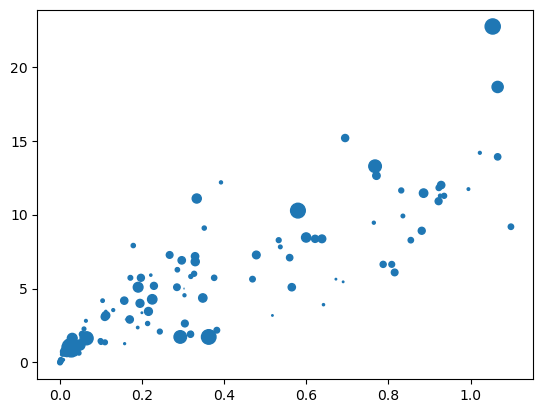

In [ ]:
common_columns = set(start_end_difference.index).intersection(average_degree.index)

difference_list = [abs(start_end_difference[col]) for col in common_columns]
average_degree_list = [average_degree[col] for col in common_columns]
average_strength_list = [average_strength[col] for col in common_columns]

plt.scatter(average_strength_list, average_degree_list, s=np.array(difference_list) * 100)
# plt.scatter(trimmed_degree_df[col], year_by_year_difference[col].abs(), s=trimmed_strength_df[col] * 100)
